In [1]:
!pip install -q efficientnet >> /dev/null

In [2]:
import os, glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img,img_to_array
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
from tensorflow.keras.applications import vgg16,resnet50,mobilenet,inception_v3,mobilenet_v2,vgg19,xception

In [3]:
SEED = 42
EPOCHS = 10
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [4]:
def preprocessingImage(image):
    test_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    test_img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
    test_img_thresh = cv.adaptiveThreshold(test_img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,3)
    cnts = cv.findContours(test_img_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        test_img_ROI = test_img[y:y+h, x:x+w]
        break
    test_img_ROI_resize = cv.resize(test_img_ROI, (IMG_WIDTH, IMG_HEIGHT))
    test_img_ROI_resize_gray = cv.cvtColor(test_img_ROI_resize, cv.COLOR_RGB2GRAY)
    
    return test_img_ROI_resize_gray

In [5]:
img_root='dataset/'
img_dir=[img_root+'normal',
         img_root+'cataract']

In [6]:
df_pr = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(1026))

filepaths = glob.glob(img_root + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df_pr.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == img_dir[0]:    # normal
        df_pr.iloc[i, 1] = 0
    elif filepath[0] == img_dir[1]:  # cataract
        df_pr.iloc[i, 1] = 1

In [7]:
df_pr.head(10)

,paths,cataract
0,dataset/normal/NL_513.jpg,0
1,dataset/normal/NL_245.png,0
2,dataset/normal/NL_543.jpg,0
3,dataset/normal/NL_208.png,0
4,dataset/normal/NL_428.jpg,0
5,dataset/normal/NL_23.png,0
6,dataset/normal/NL_481.jpg,0
7,dataset/normal/NL_459.jpg,0
8,dataset/normal/NL_575.jpg,0
9,dataset/normal/NL_537.jpg,0


In [8]:
#df_pr.to_csv('dataset/df_pr.csv')

In [9]:
train_df, test_df = train_test_split(df_pr, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df_pr['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [10]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv.imread(path)
        #img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img = cv.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [00:00<00:00, 403.40it/s]


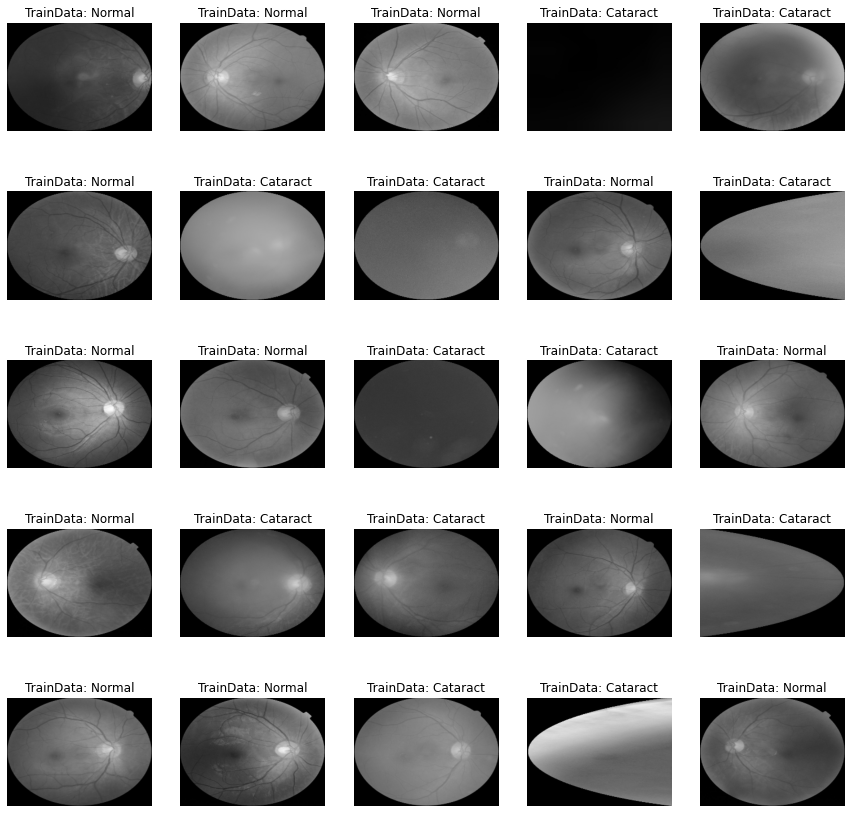

In [11]:
# plot the first 25 sheets of image data for Train
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

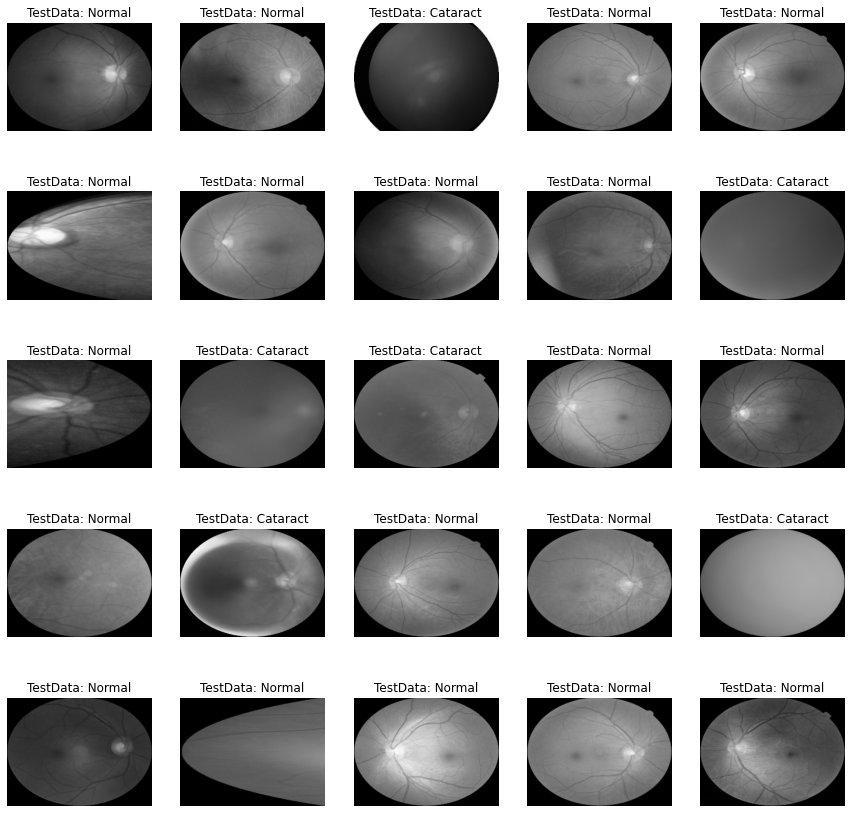

In [12]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [13]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [26]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(64, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=[2,2],strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(128, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=[2,2],strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(256, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=[2,2],strides=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 192, 256, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 192, 256, 64)      36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 192, 256, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 96, 128, 64)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 96, 128, 64)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 128, 128)      73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 128, 128)     

In [27]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 


#generator.fit(train_imgs.reshape(697,400,400,1))
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
22/21 [==============================] - 11s 502ms/step - loss: 33.7010 - accuracy: 0.5796 - val_loss: 6.7799 - val_accuracy: 0.3740
Epoch 2/100
22/21 [==============================] - 10s 444ms/step - loss: 8.6166 - accuracy: 0.6413 - val_loss: 27.0954 - val_accuracy: 0.5528
Epoch 3/100
22/21 [==============================] - 10s 449ms/step - loss: 4.5423 - accuracy: 0.6040 - val_loss: 14.5221 - val_accuracy: 0.5691
Epoch 4/100
22/21 [==============================] - 10s 446ms/step - loss: 3.6944 - accuracy: 0.6428 - val_loss: 9.7713 - val_accuracy: 0.5285
Epoch 5/100
22/21 [==============================] - 10s 445ms/step - loss: 2.5874 - accuracy: 0.6542 - val_loss: 8.8040 - val_accuracy: 0.6341
Epoch 6/100
22/21 [==============================] - 10s 446ms/step - loss: 3.1783 - accuracy: 0.6643 - val_loss: 11.4129 - val_accuracy: 0.4065
Epoch 7/100
22/21 [==============================] - 10s 466ms/step - loss: 2.0942 - accuracy: 0.6212 - val_loss: 4.2333 - val_accur

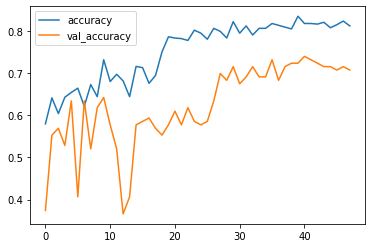

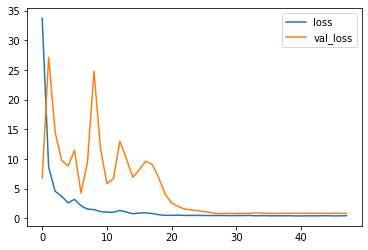

In [28]:
BS=32

history = model.fit(generator.flow(train_imgs, 
                                   train_df)
                                   ,batch_size=BS 
                    ,epochs=100,
                    steps_per_epoch=len(train_imgs)/BS,
                    callbacks=[es_callback, reduce_lr]
                    ,validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [29]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 126ms/step - loss: 1.0816 - accuracy: 0.7767


[1.0816073417663574, 0.7766990065574646]

In [30]:
model.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 135ms/step - loss: 0.5094 - accuracy: 0.7848


[0.5093970894813538, 0.7847919464111328]

In [14]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [15]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/50
22/21 [==============================] - 84s 4s/step - loss: 0.7434 - accuracy: 0.4648 - val_loss: 0.6705 - val_accuracy: 0.5691
Epoch 2/50
22/21 [==============================] - 81s 4s/step - loss: 0.6858 - accuracy: 0.5653 - val_loss: 0.6399 - val_accuracy: 0.7480
Epoch 3/50
22/21 [==============================] - 81s 4s/step - loss: 0.6490 - accuracy: 0.6284 - val_loss: 0.6573 - val_accuracy: 0.6341
Epoch 4/50
22/21 [==============================] - 81s 4s/step - loss: 0.5996 - accuracy: 0.7016 - val_loss: 0.6660 - val_accuracy: 0.5935
Epoch 5/50
22/21 [==============================] - 78s 4s/step - loss: 0.5761 - accuracy: 0.7331 - val_loss: 0.6717 - val_accuracy: 0.5528
Epoch 6/50
22/21 [==============================] - 80s 4s/step - loss: 0.5453 - accuracy: 0.7819 - val_loss: 0.6636 - val_accuracy: 0.6260
Epoch 7/50
22/21 [==============================] - 79s 4s/step - loss: 0.5042 - accuracy: 0.7920 - val_loss: 0.6491 - val_accuracy: 0.6423
Epoch 8/50
22/21 [==

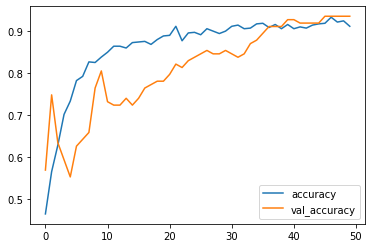

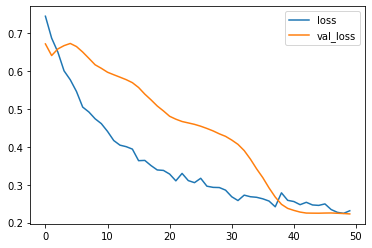

In [21]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=50,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [22]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 4s 579ms/step - loss: 0.2960 - accuracy: 0.8835


[0.2960461378097534, 0.8834951519966125]

In [23]:
model.evaluate(train_imgs, train_df)

22/22 [==============================] - 15s 700ms/step - loss: 0.2001 - accuracy: 0.9326


[0.20010823011398315, 0.9325681328773499]

In [16]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    vgg_model = vgg16.VGG16(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = vgg_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model2 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model2.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [16]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
22/21 [==============================] - 11s 493ms/step - loss: 0.6766 - accuracy: 0.5552 - val_loss: 0.6104 - val_accuracy: 0.6016
Epoch 2/100
22/21 [==============================] - 8s 355ms/step - loss: 0.5510 - accuracy: 0.6772 - val_loss: 0.4908 - val_accuracy: 0.8374
Epoch 3/100
22/21 [==============================] - 8s 355ms/step - loss: 0.4118 - accuracy: 0.8795 - val_loss: 0.3654 - val_accuracy: 0.8537
Epoch 4/100
22/21 [==============================] - 8s 358ms/step - loss: 0.2974 - accuracy: 0.8895 - val_loss: 0.3266 - val_accuracy: 0.8537
Epoch 5/100
22/21 [==============================] - 8s 358ms/step - loss: 0.3001 - accuracy: 0.8924 - val_loss: 0.3236 - val_accuracy: 0.8537
Epoch 6/100
22/21 [==============================] - 8s 360ms/step - loss: 0.2586 - accuracy: 0.9024 - val_loss: 0.3110 - val_accuracy: 0.8618
Epoch 7/100
22/21 [==============================] - 8s 362ms/step - loss: 0.2559 - accuracy: 0.9067 - val_loss: 0.3105 - val_accuracy: 0.853

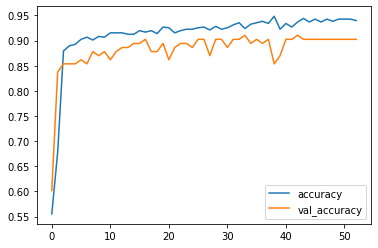

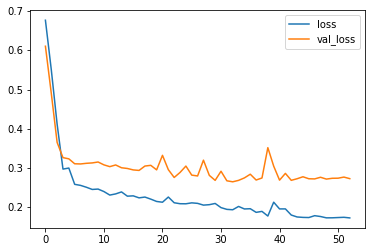

In [18]:
history = model2.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [19]:
model2.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 167ms/step - loss: 0.1934 - accuracy: 0.9272


[0.19337274134159088, 0.9271844625473022]

In [20]:
model2.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 105ms/step - loss: 0.1868 - accuracy: 0.9369


[0.18680472671985626, 0.9368723034858704]

In [21]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    inception_model = inception_v3.InceptionV3(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = inception_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model3 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model3.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 9s 399ms/step - loss: 0.6357 - accuracy: 0.6585 - val_loss: 0.5890 - val_accuracy: 0.6667
Epoch 2/100
22/21 [==============================] - 6s 277ms/step - loss: 0.5106 - accuracy: 0.7905 - val_loss: 0.5258 - val_accuracy: 0.7480
Epoch 3/100
22/21 [==============================] - 6s 269ms/step - loss: 0.4490 - accuracy: 0.8393 - val_loss: 0.4723 - val_accuracy: 0.7967
Epoch 4/100
22/21 [==============================] - 6s 271ms/step - loss: 0.4111 - accuracy: 0.8537 - val_loss: 0.4570 - val_accuracy: 0.8211
Epoch 5/100
22/21 [==============================] - 6s 266ms/step - loss: 0.3693 - accuracy: 0.8637 - val_loss: 0.4386 - val_accuracy: 0.8374
Epoch 6/100
22/21 [==============================] - 6s 268ms/step - loss: 0.3478 - accuracy: 0.8709 - val_loss: 0.4220 - val_accuracy: 0.8293
Epoch 7/100
22/21 [==============================] - 6s 268ms/step - loss: 0.3298 - accuracy: 0.8996 - val_loss: 0.4127 - val_accuracy: 0.8455

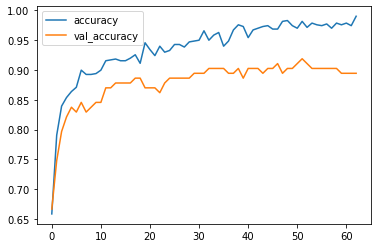

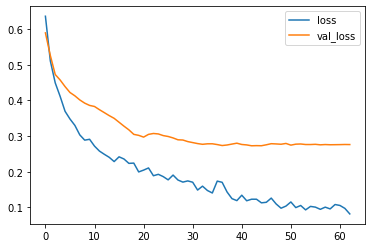

In [22]:
history = model3.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [23]:
model3.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 115ms/step - loss: 0.2189 - accuracy: 0.9175


[0.21893103420734406, 0.917475700378418]

In [24]:
model3.evaluate(train_imgs, train_df)

22/22 [==============================] - 1s 62ms/step - loss: 0.0877 - accuracy: 0.9900


[0.08770094811916351, 0.9899569749832153]

In [23]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    resnet_model = resnet50.ResNet50(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = resnet_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model4 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model4.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 9s 399ms/step - loss: 0.4923 - accuracy: 0.7805 - val_loss: 0.8834 - val_accuracy: 0.6016
Epoch 2/100
22/21 [==============================] - 7s 302ms/step - loss: 0.3691 - accuracy: 0.8623 - val_loss: 0.8019 - val_accuracy: 0.6016
Epoch 3/100
22/21 [==============================] - 7s 301ms/step - loss: 0.3069 - accuracy: 0.8809 - val_loss: 0.7354 - val_accuracy: 0.6016
Epoch 4/100
22/21 [==============================] - 7s 300ms/step - loss: 0.3018 - accuracy: 0.8852 - val_loss: 0.7336 - val_accuracy: 0.6016
Epoch 5/100
22/21 [==============================] - 7s 307ms/step - loss: 0.2636 - accuracy: 0.9053 - val_loss: 0.7236 - val_accuracy: 0.6016
Epoch 6/100
22/21 [==============================] - 7s 303ms/step - loss: 0.2598 - accuracy: 0.9024 - val_loss: 0.7127 - val_accuracy: 0.6016
Epoch 7/100
22/21 [==============================] - 7s 299ms/step - loss: 0.2221 - accuracy: 0.9240 - val_loss: 0.7159 - val_accuracy: 0.6016

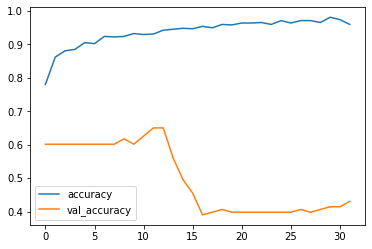

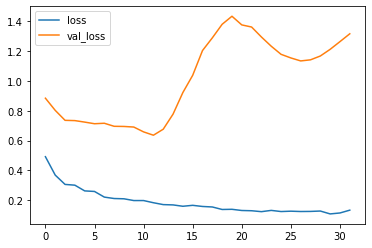

In [24]:
history = model4.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [25]:
model4.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 103ms/step - loss: 0.6370 - accuracy: 0.6893


[0.6370481252670288, 0.6893203854560852]

In [26]:
model4.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 80ms/step - loss: 0.6428 - accuracy: 0.6399


[0.6428111791610718, 0.6398852467536926]

In [25]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    mobilenet_model = mobilenet.MobileNet(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = mobilenet_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model5 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model5.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 6, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 6s 290ms/step - loss: 0.7130 - accuracy: 0.5925 - val_loss: 1.4091 - val_accuracy: 0.3984
Epoch 2/100
22/21 [==============================] - 6s 252ms/step - loss: 0.5112 - accuracy: 0.7475 - val_loss: 1.5543 - val_accuracy: 0.3984
Epoch 3/100
22/21 [==============================] - 6s 254ms/step - loss: 0.4346 - accuracy: 0.8135 - val_loss: 1.5873 - val_accuracy: 0.3984
Epoch 4/100
22/21 [==============================] - 6s 254ms/step - loss: 0.3911 - accuracy: 0.8379 - val_loss: 1.5639 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 6s 256ms/step - loss: 0.3501 - accuracy: 0.8651 - val_loss: 1.4240 - val_accuracy: 0.4065
Epoch 6/100
22/21 [==============================] - 6s 263ms/step - loss: 0.3293 - accuracy: 0.8651 - val_loss: 1.2014 - val_accuracy: 0.4472
Epoch 7/100
22/21 [==============================] - 6s 253ms/step - loss: 0.3156 - accuracy: 0.8709 - val_loss: 1.0079 - val_accuracy: 0.4959

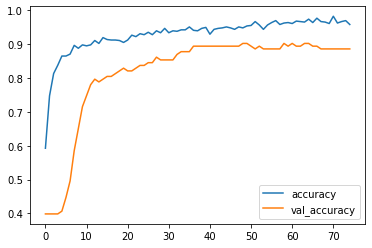

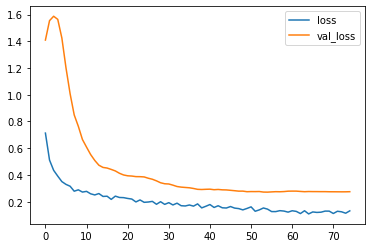

In [26]:
history = model5.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [27]:
model5.evaluate(test_imgs, test_df)

7/7 [==============================] - 0s 52ms/step - loss: 0.1921 - accuracy: 0.9320


[0.19208753108978271, 0.9320388436317444]

In [28]:
model5.evaluate(train_imgs, train_df)

22/22 [==============================] - 1s 31ms/step - loss: 0.1147 - accuracy: 0.9713


[0.11474171280860901, 0.9713056087493896]

In [29]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    mobilenet2_model = mobilenet_v2.MobileNetV2(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = mobilenet2_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model6 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model6.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


Epoch 1/50
22/21 [==============================] - 7s 301ms/step - loss: 0.8459 - accuracy: 0.4792 - val_loss: 1.0902 - val_accuracy: 0.4146
Epoch 2/50
22/21 [==============================] - 5s 249ms/step - loss: 0.6667 - accuracy: 0.6169 - val_loss: 1.1941 - val_accuracy: 0.4146
Epoch 3/50
22/21 [==============================] - 5s 249ms/step - loss: 0.5436 - accuracy: 0.7231 - val_loss: 1.2702 - val_accuracy: 0.4146
Epoch 4/50
22/21 [==============================] - 6s 253ms/step - loss: 0.4677 - accuracy: 0.7948 - val_loss: 1.3415 - val_accuracy: 0.4146
Epoch 5/50
22/21 [==============================] - 6s 252ms/step - loss: 0.4341 - accuracy: 0.8121 - val_loss: 1.4169 - val_accuracy: 0.4146
Epoch 6/50
22/21 [==============================] - 6s 252ms/step - loss: 0.3784 - accuracy: 0.8637 - val_loss: 1.4763 - val_accuracy: 0.4065
Epoch 7/50
22/21 [==============================] - 6s 251ms/step - loss: 0.3487 - accuracy: 0.8680 - val_loss: 1.5327 - val_accuracy: 0.4065
Epoch 

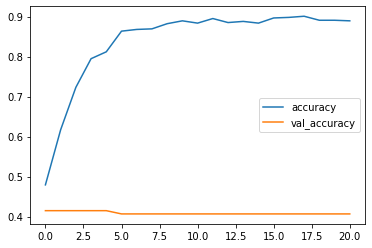

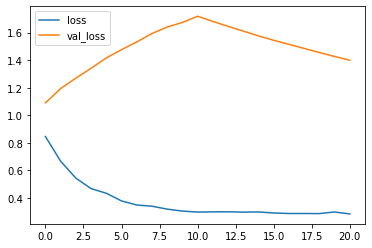

In [30]:
history = model6.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=50,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [31]:
model6.evaluate(test_imgs, test_df)

7/7 [==============================] - 0s 53ms/step - loss: 1.0994 - accuracy: 0.4126


[1.0994172096252441, 0.4126213490962982]

In [32]:
model6.evaluate(train_imgs, train_df)

22/22 [==============================] - 1s 35ms/step - loss: 1.0905 - accuracy: 0.4046


[1.0904592275619507, 0.4045911133289337]

In [29]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    vgg19_model = vgg19.VGG19(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = vgg19_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model7 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model7.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 6, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 10s 433ms/step - loss: 0.7361 - accuracy: 0.5997 - val_loss: 0.6191 - val_accuracy: 0.7398
Epoch 2/100
22/21 [==============================] - 9s 427ms/step - loss: 0.5056 - accuracy: 0.7934 - val_loss: 0.4082 - val_accuracy: 0.8862
Epoch 3/100
22/21 [==============================] - 9s 430ms/step - loss: 0.3260 - accuracy: 0.8867 - val_loss: 0.3044 - val_accuracy: 0.8780
Epoch 4/100
22/21 [==============================] - 10s 433ms/step - loss: 0.2650 - accuracy: 0.8967 - val_loss: 0.2945 - val_accuracy: 0.8780
Epoch 5/100
22/21 [==============================] - 10s 435ms/step - loss: 0.2596 - accuracy: 0.9010 - val_loss: 0.2932 - val_accuracy: 0.8943
Epoch 6/100
22/21 [==============================] - 10s 438ms/step - loss: 0.2510 - accuracy: 0.9024 - val_loss: 0.2909 - val_accuracy: 0.8862
Epoch 7/100
22/21 [==============================] - 10s 435ms/step - loss: 0.2464 - accuracy: 0.9139 - val_loss: 0.2914 - val_accuracy: 0

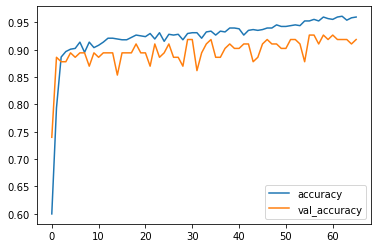

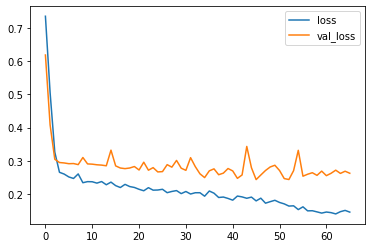

In [30]:
history = model7.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [31]:
model7.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 97ms/step - loss: 0.1894 - accuracy: 0.9320


[0.1893555372953415, 0.9320388436317444]

In [32]:
model7.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 116ms/step - loss: 0.1687 - accuracy: 0.9469


[0.16873517632484436, 0.946915328502655]

In [39]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    xception_model = xception.Xception(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = xception_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model8 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model8.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 6, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 14s 615ms/step - loss: 0.6194 - accuracy: 0.6585 - val_loss: 0.6812 - val_accuracy: 0.5854
Epoch 2/100
22/21 [==============================] - 11s 506ms/step - loss: 0.5553 - accuracy: 0.7805 - val_loss: 0.6276 - val_accuracy: 0.6016
Epoch 3/100
22/21 [==============================] - 11s 505ms/step - loss: 0.4989 - accuracy: 0.8207 - val_loss: 0.5743 - val_accuracy: 0.7236
Epoch 4/100
22/21 [==============================] - 11s 512ms/step - loss: 0.4499 - accuracy: 0.8494 - val_loss: 0.5276 - val_accuracy: 0.7805
Epoch 5/100
22/21 [==============================] - 11s 515ms/step - loss: 0.4266 - accuracy: 0.8551 - val_loss: 0.4878 - val_accuracy: 0.7967
Epoch 6/100
22/21 [==============================] - 11s 521ms/step - loss: 0.3889 - accuracy: 0.8666 - val_loss: 0.4535 - val_accuracy: 0.7967
Epoch 7/100
22/21 [==============================] - 12s 528ms/step - loss: 0.3705 - accuracy: 0.8651 - val_loss: 0.4268 - val_accuracy:

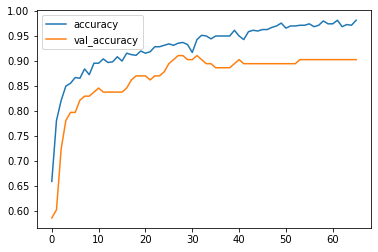

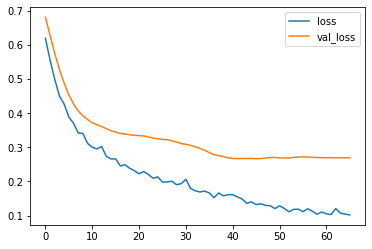

In [40]:
history = model8.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [41]:
model8.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 137ms/step - loss: 0.2029 - accuracy: 0.9369


[0.20288972556591034, 0.9368932247161865]

In [42]:
model8.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 104ms/step - loss: 0.1205 - accuracy: 0.9699


[0.12045850604772568, 0.9698708653450012]

In [64]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model9 = Sequential()

#Layer1
model9.add(Conv2D(64, kernel_size=[3,3], padding='same', input_shape=input_shape, activation='mish'))
model9.add(Conv2D(64, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(BatchNormalization())
model9.add(MaxPool2D(pool_size=[2,2],strides=2))
model9.add(Dropout(0.3))

#Layer2
model9.add(Conv2D(128, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(Conv2D(128, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(BatchNormalization())
model9.add(MaxPool2D(pool_size=[2,2],strides=2))
model9.add(Dropout(0.3))

#Layer3
model9.add(Conv2D(256, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(Conv2D(256, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(BatchNormalization())
model9.add(MaxPool2D(pool_size=[2,2],strides=2))
model9.add(Dropout(0.3))

#Layer4
model9.add(Conv2D(512, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(Conv2D(512, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(BatchNormalization())
model9.add(MaxPool2D(pool_size=[2,2],strides=2))
model9.add(Dropout(0.3))

#Layer5
model9.add(Conv2D(512, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(Conv2D(512, kernel_size=[3,3], padding='same', activation='mish'))
model9.add(BatchNormalization())
model9.add(MaxPool2D(pool_size=[2,2],strides=2))
model9.add(Dropout(0.3))

#FC Layers
model9.add(Flatten())
model9.add(Dense(4096, activation='relu'))
model9.add(Dense(4096, activation='relu'))
model9.add(Dense(1000, activation='relu'))
model9.add(Dropout(0.4))
model9.add(Dense(2, activation='softmax'))
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model9.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 192, 256, 64)      1792      
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 192, 256, 64)      36928     
_________________________________________________________________
batch_normalization_111 (Bat (None, 192, 256, 64)      256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 96, 128, 64)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 96, 128, 64)       0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 96, 128, 128)      73856     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 96, 128, 128)     

Epoch 1/100
22/21 [==============================] - 12s 542ms/step - loss: 18.3796 - accuracy: 0.5423 - val_loss: 198.9905 - val_accuracy: 0.3984
Epoch 2/100
22/21 [==============================] - 12s 531ms/step - loss: 1.6637 - accuracy: 0.5696 - val_loss: 39.0731 - val_accuracy: 0.4065
Epoch 3/100
22/21 [==============================] - 12s 533ms/step - loss: 0.9904 - accuracy: 0.6169 - val_loss: 9.2986 - val_accuracy: 0.4065
Epoch 4/100
22/21 [==============================] - 11s 509ms/step - loss: 0.6769 - accuracy: 0.6528 - val_loss: 12.8890 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 12s 536ms/step - loss: 0.6812 - accuracy: 0.6829 - val_loss: 1.6565 - val_accuracy: 0.3984
Epoch 6/100
22/21 [==============================] - 11s 514ms/step - loss: 0.6069 - accuracy: 0.7059 - val_loss: 3.8921 - val_accuracy: 0.3984
Epoch 7/100
22/21 [==============================] - 11s 516ms/step - loss: 0.6535 - accuracy: 0.6987 - val_loss: 3.9359 - val_accu

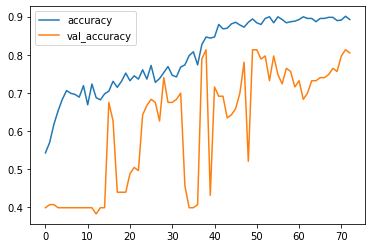

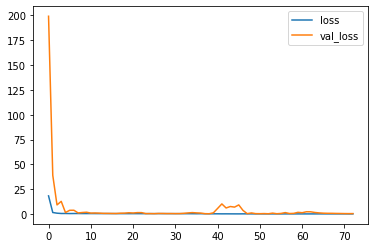

In [65]:
history = model9.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [66]:
model9.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 125ms/step - loss: 0.3755 - accuracy: 0.8689


[0.3754558861255646, 0.8689320683479309]

In [67]:
model9.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 152ms/step - loss: 0.2804 - accuracy: 0.8867


[0.2803501784801483, 0.8866571187973022]

In [44]:
from tensorflow.keras.applications import DenseNet201,inception_resnet_v2, ResNet152, ResNet101

In [72]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    resnet152_model = ResNet152(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = resnet152_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model10 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model10.summary()

234700800/234698864 [==============================] - 1s 0us/step
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, 6, 8, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 4098      
Total params: 58,375,042
Trainable params: 58,223,618
Non-trainable params: 151,424
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 19s 868ms/step - loss: 0.6628 - accuracy: 0.6284 - val_loss: 0.7606 - val_accuracy: 0.3984
Epoch 2/100
22/21 [==============================] - 15s 681ms/step - loss: 0.3983 - accuracy: 0.8307 - val_loss: 0.8002 - val_accuracy: 0.3984
Epoch 3/100
22/21 [==============================] - 15s 676ms/step - loss: 0.3244 - accuracy: 0.8766 - val_loss: 0.8808 - val_accuracy: 0.3984
Epoch 4/100
22/21 [==============================] - 15s 674ms/step - loss: 0.2781 - accuracy: 0.8996 - val_loss: 1.0832 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 15s 673ms/step - loss: 0.2468 - accuracy: 0.9154 - val_loss: 1.4137 - val_accuracy: 0.3984
Epoch 6/100
22/21 [==============================] - 15s 672ms/step - loss: 0.2392 - accuracy: 0.9182 - val_loss: 1.7677 - val_accuracy: 0.3984
Epoch 7/100
22/21 [==============================] - 15s 672ms/step - loss: 0.2164 - accuracy: 0.9311 - val_loss: 2.0669 - val_accuracy:

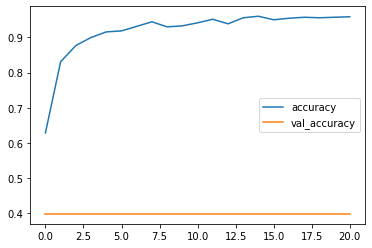

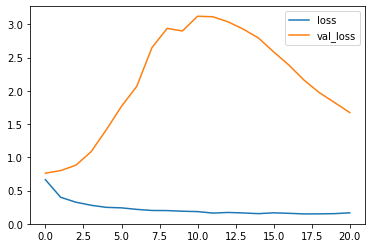

In [73]:
history = model10.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [74]:
model10.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 178ms/step - loss: 0.7674 - accuracy: 0.4029


[0.7673840522766113, 0.40291261672973633]

In [75]:
model10.evaluate(train_imgs, train_df)

22/22 [==============================] - 4s 174ms/step - loss: 0.7648 - accuracy: 0.4003


[0.7648360729217529, 0.4002869427204132]

In [76]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    resnet101_model = ResNet101(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = resnet101_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model11 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model11.summary()

171450368/171446536 [==============================] - 1s 0us/step
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 6, 8, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 4098      
Total params: 42,662,274
Trainable params: 42,556,930
Non-trainable params: 105,344
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 12s 551ms/step - loss: 0.6738 - accuracy: 0.6098 - val_loss: 0.6917 - val_accuracy: 0.6016
Epoch 2/100
22/21 [==============================] - 10s 467ms/step - loss: 0.3964 - accuracy: 0.8565 - val_loss: 0.6976 - val_accuracy: 0.6016
Epoch 3/100
22/21 [==============================] - 10s 469ms/step - loss: 0.3199 - accuracy: 0.8824 - val_loss: 0.6969 - val_accuracy: 0.6016
Epoch 4/100
22/21 [==============================] - 11s 481ms/step - loss: 0.2906 - accuracy: 0.8881 - val_loss: 0.6873 - val_accuracy: 0.6016
Epoch 5/100
22/21 [==============================] - 11s 479ms/step - loss: 0.2618 - accuracy: 0.9039 - val_loss: 0.6823 - val_accuracy: 0.6016
Epoch 6/100
22/21 [==============================] - 10s 471ms/step - loss: 0.2439 - accuracy: 0.9067 - val_loss: 0.6921 - val_accuracy: 0.5447
Epoch 7/100
22/21 [==============================] - 10s 472ms/step - loss: 0.2562 - accuracy: 0.9024 - val_loss: 0.6974 - val_accuracy:

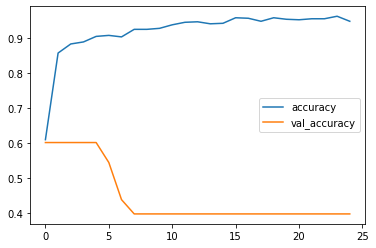

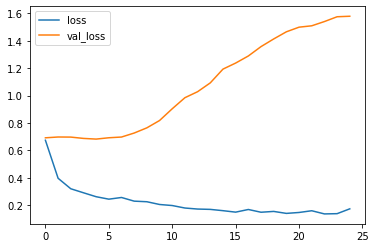

In [77]:
history = model11.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [78]:
model11.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 107ms/step - loss: 0.6853 - accuracy: 0.5971


[0.6852508187294006, 0.5970873832702637]

In [79]:
model11.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 126ms/step - loss: 0.6850 - accuracy: 0.5983


[0.6850255131721497, 0.5982783436775208]

In [82]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    incres_model = inception_resnet_v2.InceptionResNetV2(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = incres_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model12 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model12.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 16s 725ms/step - loss: 0.6288 - accuracy: 0.6686 - val_loss: 0.7119 - val_accuracy: 0.6585
Epoch 2/100
22/21 [==============================] - 11s 503ms/step - loss: 0.5444 - accuracy: 0.7805 - val_loss: 0.5999 - val_accuracy: 0.6911
Epoch 3/100
22/21 [==============================] - 11s 506ms/step - loss: 0.4787 - accuracy: 0.8422 - val_loss: 0.5311 - val_accuracy: 0.7480
Epoch 4/100
22/21 [==============================] - 11s 505ms/step - loss: 0.4335 - accuracy: 0.8709 - val_loss: 0.4818 - val_accuracy: 0.7642
Epoch 5/100
22/21 [==============================] - 11s 508ms/step - loss: 0.3977 - accuracy: 0.8752 - val_loss: 0.4482 - val_accuracy: 0.7967
Epoch 6/100
22/21 [==============================] - 11s 510ms/step - loss: 0.3642 - accuracy: 0.8780 - val_loss: 0.4163 - val_accuracy: 0.8130
Epoch 7/100
22/21 [==============================] - 11s 513ms/step - loss: 0.3319 - accuracy: 0.8967 - val_loss: 0.3921 - val_accuracy:

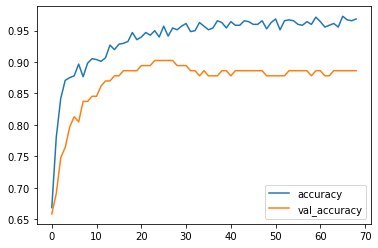

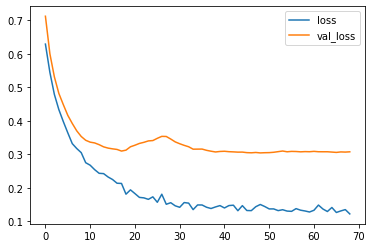

In [83]:
history = model12.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [84]:
model12.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 148ms/step - loss: 0.2187 - accuracy: 0.9175


[0.2187218964099884, 0.917475700378418]

In [85]:
model12.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 138ms/step - loss: 0.1088 - accuracy: 0.9785


[0.10881093144416809, 0.9784792065620422]

In [46]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    densenet_model = DenseNet201(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = densenet_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model13 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model13.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 6, 8, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3842      
Total params: 18,325,826
Trainable params: 18,096,770
Non-trainable params: 229,056
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 17s 795ms/step - loss: 0.5421 - accuracy: 0.7317 - val_loss: 0.5060 - val_accuracy: 0.7317
Epoch 2/100
22/21 [==============================] - 10s 477ms/step - loss: 0.4066 - accuracy: 0.8479 - val_loss: 0.4957 - val_accuracy: 0.8049
Epoch 3/100
22/21 [==============================] - 11s 479ms/step - loss: 0.3254 - accuracy: 0.8838 - val_loss: 0.4884 - val_accuracy: 0.8374
Epoch 4/100
22/21 [==============================] - 10s 471ms/step - loss: 0.3279 - accuracy: 0.8666 - val_loss: 0.4900 - val_accuracy: 0.8374
Epoch 5/100
22/21 [==============================] - 10s 472ms/step - loss: 0.2792 - accuracy: 0.8924 - val_loss: 0.4999 - val_accuracy: 0.7967
Epoch 6/100
22/21 [==============================] - 10s 473ms/step - loss: 0.2566 - accuracy: 0.9110 - val_loss: 0.5147 - val_accuracy: 0.7886
Epoch 7/100
22/21 [==============================] - 10s 476ms/step - loss: 0.2500 - accuracy: 0.9110 - val_loss: 0.5238 - val_accuracy:

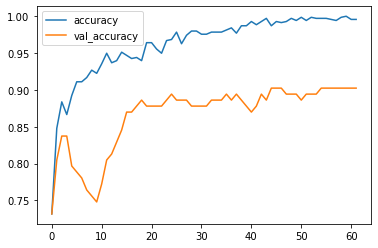

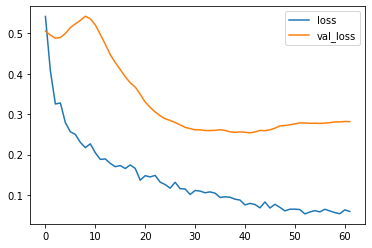

In [47]:
history = model13.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [48]:
model13.evaluate(test_imgs, test_df)

7/7 [==============================] - 2s 236ms/step - loss: 0.2084 - accuracy: 0.9369


[0.20842643082141876, 0.9368932247161865]

In [49]:
model13.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 116ms/step - loss: 0.0745 - accuracy: 0.9943


[0.07445386052131653, 0.9942611455917358]

In [39]:
from tensorflow.keras.applications import DenseNet169, DenseNet121, EfficientNetB7, NASNetLarge 

In [51]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    densenet1_model = DenseNet169(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = densenet1_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model14 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model14.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3330      
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 11s 487ms/step - loss: 0.9103 - accuracy: 0.4620 - val_loss: 0.7319 - val_accuracy: 0.5122
Epoch 2/100
22/21 [==============================] - 8s 358ms/step - loss: 0.6356 - accuracy: 0.6413 - val_loss: 0.9189 - val_accuracy: 0.4065
Epoch 3/100
22/21 [==============================] - 8s 360ms/step - loss: 0.5104 - accuracy: 0.7848 - val_loss: 1.1880 - val_accuracy: 0.3984
Epoch 4/100
22/21 [==============================] - 8s 361ms/step - loss: 0.4184 - accuracy: 0.8393 - val_loss: 1.4197 - val_accuracy: 0.3984
Epoch 5/100
22/21 [==============================] - 8s 362ms/step - loss: 0.3724 - accuracy: 0.8637 - val_loss: 1.5730 - val_accuracy: 0.3984
Epoch 6/100
22/21 [==============================] - 8s 363ms/step - loss: 0.3494 - accuracy: 0.8809 - val_loss: 1.6498 - val_accuracy: 0.3984
Epoch 7/100
22/21 [==============================] - 8s 364ms/step - loss: 0.3003 - accuracy: 0.8981 - val_loss: 1.6575 - val_accuracy: 0.398

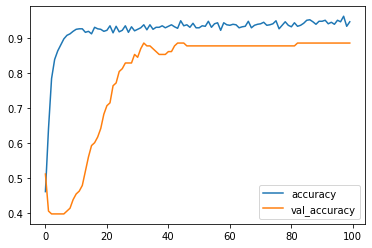

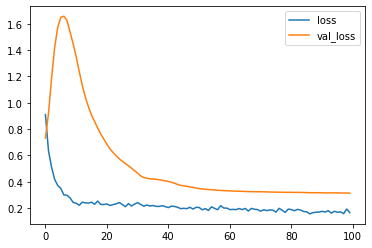

In [52]:
history = model14.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [53]:
model14.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 94ms/step - loss: 0.2066 - accuracy: 0.9272


[0.20662446320056915, 0.9271844625473022]

In [54]:
model14.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 95ms/step - loss: 0.1454 - accuracy: 0.9584


[0.14543935656547546, 0.9583930969238281]

In [55]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    densenet2_model = DenseNet121(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = densenet2_model(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model15 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model15.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 6, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 9s 388ms/step - loss: 0.7815 - accuracy: 0.5352 - val_loss: 0.6266 - val_accuracy: 0.6179
Epoch 2/100
22/21 [==============================] - 7s 301ms/step - loss: 0.5091 - accuracy: 0.7719 - val_loss: 0.6266 - val_accuracy: 0.6585
Epoch 3/100
22/21 [==============================] - 7s 310ms/step - loss: 0.4039 - accuracy: 0.8551 - val_loss: 0.6248 - val_accuracy: 0.7073
Epoch 4/100
22/21 [==============================] - 7s 304ms/step - loss: 0.3434 - accuracy: 0.8795 - val_loss: 0.6250 - val_accuracy: 0.6992
Epoch 5/100
22/21 [==============================] - 7s 304ms/step - loss: 0.3266 - accuracy: 0.8924 - val_loss: 0.6351 - val_accuracy: 0.6667
Epoch 6/100
22/21 [==============================] - 7s 305ms/step - loss: 0.2713 - accuracy: 0.9110 - val_loss: 0.6450 - val_accuracy: 0.6341
Epoch 7/100
22/21 [==============================] - 7s 322ms/step - loss: 0.2839 - accuracy: 0.9039 - val_loss: 0.6373 - val_accuracy: 0.6667

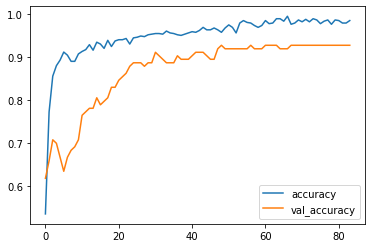

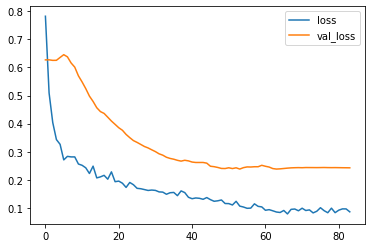

In [56]:
history = model15.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [57]:
model15.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 74ms/step - loss: 0.1982 - accuracy: 0.9223


[0.1982436627149582, 0.9223300814628601]

In [58]:
model15.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 76ms/step - loss: 0.0799 - accuracy: 0.9885


[0.07989627122879028, 0.9885222315788269]

In [36]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB1(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model16 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model16.summary()

27164672/27164032 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Functional) (None, 6, 8, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2562      
Total params: 6,577,794
Trainable params: 6,515,746
Non-trainable params: 62,048
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 8s 376ms/step - loss: 0.6652 - accuracy: 0.5897 - val_loss: 0.7407 - val_accuracy: 0.4715
Epoch 2/100
22/21 [==============================] - 8s 377ms/step - loss: 0.5981 - accuracy: 0.7303 - val_loss: 0.7906 - val_accuracy: 0.4065
Epoch 3/100
22/21 [==============================] - 8s 376ms/step - loss: 0.5684 - accuracy: 0.7389 - val_loss: 0.7785 - val_accuracy: 0.4065
Epoch 4/100
22/21 [==============================] - 8s 376ms/step - loss: 0.5574 - accuracy: 0.7690 - val_loss: 0.7364 - val_accuracy: 0.4228
Epoch 5/100
22/21 [==============================] - 8s 381ms/step - loss: 0.5255 - accuracy: 0.8034 - val_loss: 0.7053 - val_accuracy: 0.4797
Epoch 6/100
22/21 [==============================] - 8s 381ms/step - loss: 0.4933 - accuracy: 0.8192 - val_loss: 0.6857 - val_accuracy: 0.5203
Epoch 7/100
22/21 [==============================] - 8s 381ms/step - loss: 0.4871 - accuracy: 0.8149 - val_loss: 0.6669 - val_accuracy: 0.5691

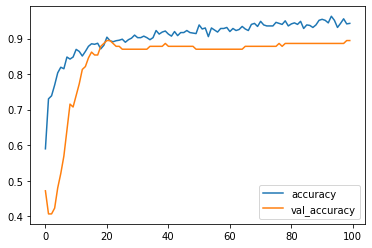

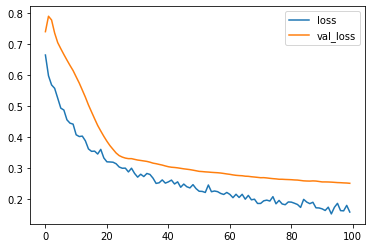

In [79]:
history = model16.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [80]:
model16.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 98ms/step - loss: 0.1922 - accuracy: 0.9272


[0.19224196672439575, 0.9271844625473022]

In [81]:
model16.evaluate(train_imgs, train_df)

22/22 [==============================] - 1s 68ms/step - loss: 0.1219 - accuracy: 0.9670


[0.12191490828990936, 0.9670014381408691]

In [43]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB2(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model17 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model17.summary()

31940608/31936256 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Functional) (None, 6, 8, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 2818      
Total params: 7,771,380
Trainable params: 7,703,812
Non-trainable params: 67,568
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 12s 525ms/step - loss: 0.6574 - accuracy: 0.6069 - val_loss: 0.6768 - val_accuracy: 0.5610
Epoch 2/100
22/21 [==============================] - 9s 400ms/step - loss: 0.6110 - accuracy: 0.6815 - val_loss: 0.6658 - val_accuracy: 0.5528
Epoch 3/100
22/21 [==============================] - 9s 397ms/step - loss: 0.5671 - accuracy: 0.7231 - val_loss: 0.6613 - val_accuracy: 0.5528
Epoch 4/100
22/21 [==============================] - 9s 396ms/step - loss: 0.5296 - accuracy: 0.7676 - val_loss: 0.6674 - val_accuracy: 0.5366
Epoch 5/100
22/21 [==============================] - 9s 395ms/step - loss: 0.4941 - accuracy: 0.8020 - val_loss: 0.6744 - val_accuracy: 0.5366
Epoch 6/100
22/21 [==============================] - 9s 406ms/step - loss: 0.4734 - accuracy: 0.8077 - val_loss: 0.6814 - val_accuracy: 0.5366
Epoch 7/100
22/21 [==============================] - 9s 398ms/step - loss: 0.4540 - accuracy: 0.8250 - val_loss: 0.6886 - val_accuracy: 0.536

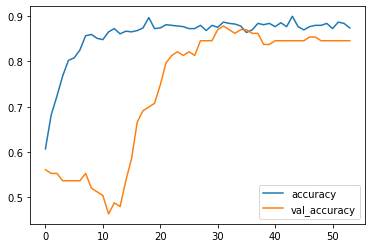

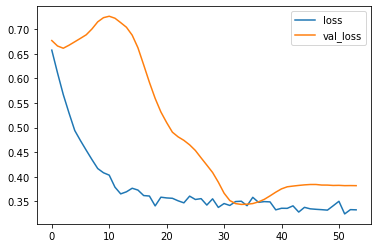

In [44]:
history = model17.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [45]:
model17.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 104ms/step - loss: 0.3334 - accuracy: 0.9029


[0.33339235186576843, 0.9029126167297363]

In [46]:
model17.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 74ms/step - loss: 0.3175 - accuracy: 0.8766


[0.31754520535469055, 0.8766140341758728]

In [24]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB3(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model18 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model18.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b3 (Functional) (None, 6, 8, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3074      
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


Epoch 1/200
22/21 [==============================] - 13s 584ms/step - loss: 0.6843 - accuracy: 0.5696 - val_loss: 0.6656 - val_accuracy: 0.6504
Epoch 2/200
22/21 [==============================] - 11s 497ms/step - loss: 0.6441 - accuracy: 0.6227 - val_loss: 0.6921 - val_accuracy: 0.5528
Epoch 3/200
22/21 [==============================] - 11s 493ms/step - loss: 0.5998 - accuracy: 0.6958 - val_loss: 0.7134 - val_accuracy: 0.4959
Epoch 4/200
22/21 [==============================] - 11s 495ms/step - loss: 0.5756 - accuracy: 0.7317 - val_loss: 0.7129 - val_accuracy: 0.5203
Epoch 5/200
22/21 [==============================] - 11s 497ms/step - loss: 0.5218 - accuracy: 0.7891 - val_loss: 0.7198 - val_accuracy: 0.5285
Epoch 6/200
22/21 [==============================] - 11s 500ms/step - loss: 0.5049 - accuracy: 0.8077 - val_loss: 0.7181 - val_accuracy: 0.5122
Epoch 7/200
22/21 [==============================] - 11s 505ms/step - loss: 0.4709 - accuracy: 0.8321 - val_loss: 0.7045 - val_accuracy:

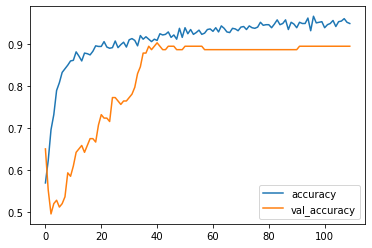

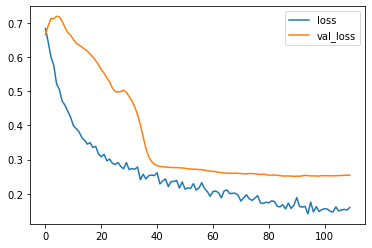

In [25]:
history = model18.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=200,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [26]:
model18.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 79ms/step - loss: 0.2209 - accuracy: 0.9272


[0.2208963930606842, 0.9271844625473022]

In [27]:
model18.evaluate(train_imgs, train_df)

22/22 [==============================] - 2s 93ms/step - loss: 0.1236 - accuracy: 0.9684


[0.12360113859176636, 0.9684361815452576]

In [14]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB4(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model19 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model19.summary()

71892992/71892840 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 6, 8, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3586      
Total params: 17,677,402
Trainable params: 17,552,202
Non-trainable params: 125,200
_________________________________________________________________


Epoch 1/100
22/21 [==============================] - 18s 833ms/step - loss: 0.6330 - accuracy: 0.6413 - val_loss: 0.7453 - val_accuracy: 0.3740
Epoch 2/100
22/21 [==============================] - 14s 655ms/step - loss: 0.5873 - accuracy: 0.7446 - val_loss: 0.7351 - val_accuracy: 0.4065
Epoch 3/100
22/21 [==============================] - 15s 661ms/step - loss: 0.5404 - accuracy: 0.7834 - val_loss: 0.7186 - val_accuracy: 0.4553
Epoch 4/100
22/21 [==============================] - 14s 656ms/step - loss: 0.5265 - accuracy: 0.7934 - val_loss: 0.7169 - val_accuracy: 0.4797
Epoch 5/100
22/21 [==============================] - 15s 661ms/step - loss: 0.5049 - accuracy: 0.8034 - val_loss: 0.7171 - val_accuracy: 0.4878
Epoch 6/100
22/21 [==============================] - 15s 661ms/step - loss: 0.4599 - accuracy: 0.8451 - val_loss: 0.7125 - val_accuracy: 0.5203
Epoch 7/100
22/21 [==============================] - 15s 667ms/step - loss: 0.4571 - accuracy: 0.8379 - val_loss: 0.7089 - val_accuracy:

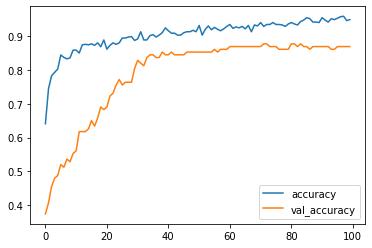

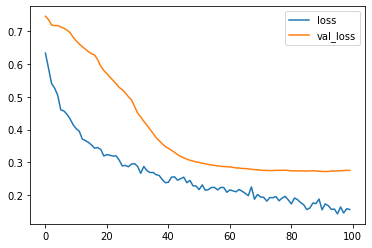

In [17]:
history = model19.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [18]:
model19.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 153ms/step - loss: 0.2118 - accuracy: 0.9272


[0.2118120640516281, 0.9271844625473022]

In [19]:
model19.evaluate(train_imgs, train_df)

22/22 [==============================] - 3s 123ms/step - loss: 0.1072 - accuracy: 0.9799


[0.10720818489789963, 0.9799138903617859]